In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nandeeshhu/pancrease-ct-segmenatation")

print("Dataset downloaded to:", path)


Using Colab cache for faster access to the 'pancrease-ct-segmenatation' dataset.
Dataset downloaded to: /kaggle/input/pancrease-ct-segmenatation


In [5]:
import os

for root, dirs, files in os.walk(path, topdown=True):
    print(root, len(files), "files")


/kaggle/input/pancrease-ct-segmenatation 0 files
/kaggle/input/pancrease-ct-segmenatation/images 0 files
/kaggle/input/pancrease-ct-segmenatation/images/negative 12060 files
/kaggle/input/pancrease-ct-segmenatation/images/positive 6882 files
/kaggle/input/pancrease-ct-segmenatation/masks 0 files
/kaggle/input/pancrease-ct-segmenatation/masks/negative 12060 files
/kaggle/input/pancrease-ct-segmenatation/masks/positive 6882 files


In [8]:
import os
import shutil
import random

# Source directories
base_path = "/kaggle/input/pancrease-ct-segmenatation/images"
neg_src = os.path.join(base_path, "negative")
pos_src = os.path.join(base_path, "positive")

# Destination small dataset
dst_root = "/content/small_pancreas_dataset"
neg_dst = os.path.join(dst_root, "normal")
pos_dst = os.path.join(dst_root, "tumor")

os.makedirs(neg_dst, exist_ok=True)
os.makedirs(pos_dst, exist_ok=True)

# Choose exactly 400 random samples from each class
neg_files = random.sample(os.listdir(neg_src), 400)
pos_files = random.sample(os.listdir(pos_src), 400)

# Copy files
for f in neg_files:
    shutil.copy(os.path.join(neg_src, f), neg_dst)

for f in pos_files:
    shutil.copy(os.path.join(pos_src, f), pos_dst)

print("DONE!")
print("Normal images:", len(os.listdir(neg_dst)))
print("Tumor images:", len(os.listdir(pos_dst)))


DONE!
Normal images: 400
Tumor images: 400


In [9]:
!find /content/small_pancreas_dataset -type f | wc -l
!find /content/small_pancreas_dataset -type d -maxdepth 1


800
find: warning: you have specified the global option -maxdepth after the argument -type, but global options are not positional, i.e., -maxdepth affects tests specified before it as well as those specified after it.  Please specify global options before other arguments.
/content/small_pancreas_dataset
/content/small_pancreas_dataset/normal
/content/small_pancreas_dataset/tumor


In [10]:
import os
import shutil
import random

source_root = "/content/small_pancreas_dataset"
dest_root = "/content/small_pancreas_dataset_split"

# Create folder structure
train_normal = os.path.join(dest_root, "train/normal")
train_tumor  = os.path.join(dest_root, "train/tumor")
test_normal  = os.path.join(dest_root, "test/normal")
test_tumor   = os.path.join(dest_root, "test/tumor")

os.makedirs(train_normal, exist_ok=True)
os.makedirs(train_tumor, exist_ok=True)
os.makedirs(test_normal, exist_ok=True)
os.makedirs(test_tumor, exist_ok=True)

# Helper function
def split_and_copy(src, train_dst, test_dst, train_ratio=0.8):
    files = os.listdir(src)
    random.shuffle(files)

    train_count = int(len(files) * train_ratio)
    train_files = files[:train_count]
    test_files  = files[train_count:]

    for f in train_files:
        shutil.copy(os.path.join(src, f), train_dst)

    for f in test_files:
        shutil.copy(os.path.join(src, f), test_dst)

    return len(train_files), len(test_files)

# Split Normal (400 total)
normal_src = os.path.join(source_root, "normal")
normal_train, normal_test = split_and_copy(normal_src, train_normal, test_normal)

# Split Tumor (400 total)
tumor_src = os.path.join(source_root, "tumor")
tumor_train, tumor_test = split_and_copy(tumor_src, train_tumor, test_tumor)

print("DONE — Train/Test split complete!\n")
print(f"TRAIN normal: {normal_train}")
print(f"TRAIN tumor : {tumor_train}")
print(f"TEST normal:  {normal_test}")
print(f"TEST tumor :  {tumor_test}")


DONE — Train/Test split complete!

TRAIN normal: 320
TRAIN tumor : 320
TEST normal:  80
TEST tumor :  80


In [11]:
import os
import torch
import random
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


In [14]:
train_dir = "/content/small_pancreas_dataset_split/train"
test_dir  = "/content/small_pancreas_dataset_split/test"

train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),

    # --- SAFE MEDICAL AUGMENTATIONS ---
    transforms.RandomRotation(3),                     # reduced, safer
    transforms.RandomAffine(degrees=0, translate=(0.03, 0.03)),

    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],
                         [0.5, 0.5, 0.5])
])

test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],
                         [0.5, 0.5, 0.5])
])

train_ds = datasets.ImageFolder(train_dir, transform=train_transforms)
test_ds  = datasets.ImageFolder(test_dir,  transform=test_transforms)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

print("Train size:", len(train_ds))
print("Test size:", len(test_ds))
print("Classes:", train_ds.class_to_idx)


Train size: 640
Test size: 160
Classes: {'normal': 0, 'tumor': 1}


Loaded: /content/small_pancreas_dataset_split/train/normal/img_04069.png


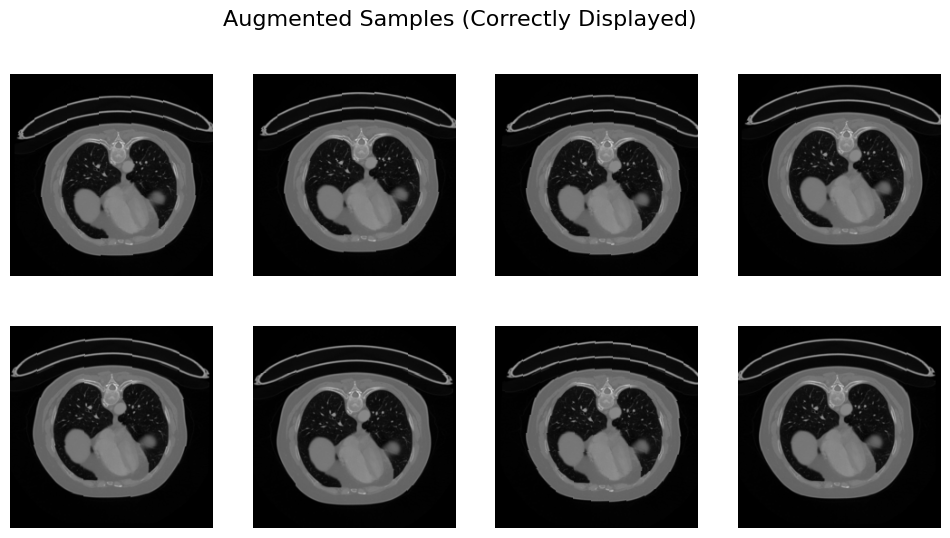

In [15]:
import matplotlib.pyplot as plt
from PIL import Image
import random
import os
import torch

# Unnormalize function
def unnormalize(t):
    return t * 0.5 + 0.5   # since std=0.5, mean=0.5

# pick random image
sample_class_dir = os.path.join(train_dir, random.choice(os.listdir(train_dir)))
sample_img_path = os.path.join(sample_class_dir, random.choice(os.listdir(sample_class_dir)))

img = Image.open(sample_img_path)

print("Loaded:", sample_img_path)

augmented = [train_transforms(img) for _ in range(8)]

plt.figure(figsize=(12,6))

for i, aug in enumerate(augmented):
    aug = unnormalize(aug)       # <-- KEY FIX
    aug = aug.clamp(0,1)         # keep in valid range
    aug_np = aug.permute(1,2,0).numpy()

    plt.subplot(2,4,i+1)
    plt.imshow(aug_np, cmap='gray')
    plt.axis("off")

plt.suptitle("Augmented Samples (Correctly Displayed)", fontsize=16)
plt.show()


In [16]:
# --- CBAM ---
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg = torch.mean(x, dim=1, keepdim=True)
        max_, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg, max_], dim=1)
        x = self.conv(x)
        return self.sigmoid(x)


class CBAM(nn.Module):
    def __init__(self, planes):
        super(CBAM, self).__init__()
        self.ca = ChannelAttention(planes)
        self.sa = SpatialAttention()

    def forward(self, x):
        out = x * self.ca(x)
        out = out * self.sa(out)
        return out


In [17]:
class ResNet50_CBAM(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

        self.cbam1 = CBAM(256)
        self.cbam2 = CBAM(512)
        self.cbam3 = CBAM(1024)
        self.cbam4 = CBAM(2048)

        self.model.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)

        x = self.model.layer1(x)
        x = self.cbam1(x)

        x = self.model.layer2(x)
        x = self.cbam2(x)

        x = self.model.layer3(x)
        x = self.cbam3(x)

        x = self.model.layer4(x)
        x = self.cbam4(x)

        x = self.model.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.model.fc(x)
        return x


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet50_CBAM(num_classes=2).to(device)



Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 170MB/s]


In [19]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=3e-5,
    weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=10,
    eta_min=1e-6
)

In [20]:
def train_one_epoch():
    model.train()
    total, correct, loss_sum = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Mixed Precision
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()

        # Gradient Clipping
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=3.0)

        scaler.step(optimizer)
        scaler.update()

        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
        loss_sum += loss.item()

    return correct/total, loss_sum/len(train_loader)


def test_eval():
    model.eval()
    total, correct = 0, 0
    preds_all, labels_all = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            with torch.cuda.amp.autocast():
                outputs = model(images)

            _, preds = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (preds == labels).sum().item()

            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())

    return correct/total, preds_all, labels_all


In [21]:
scaler = torch.cuda.amp.GradScaler()

for epoch in range(30):
    train_acc, train_loss = train_one_epoch()
    test_acc, preds, labels = test_eval()

    scheduler.step()

    print(f"Epoch {epoch+1} | "
          f"Train Acc: {train_acc:.4f} | Train Loss: {train_loss:.4f} | "
          f"Test Acc: {test_acc:.4f}")


/tmp/ipython-input-3693129167.py:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipython-input-3714156039.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-3714156039.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1 | Train Acc: 0.5281 | Train Loss: 0.6833 | Test Acc: 0.5000
Epoch 2 | Train Acc: 0.5859 | Train Loss: 0.6532 | Test Acc: 0.5062
Epoch 3 | Train Acc: 0.6031 | Train Loss: 0.6374 | Test Acc: 0.5875
Epoch 4 | Train Acc: 0.6078 | Train Loss: 0.6216 | Test Acc: 0.6000
Epoch 5 | Train Acc: 0.5906 | Train Loss: 0.6099 | Test Acc: 0.6062
Epoch 6 | Train Acc: 0.6109 | Train Loss: 0.5885 | Test Acc: 0.6062
Epoch 7 | Train Acc: 0.6094 | Train Loss: 0.5713 | Test Acc: 0.6562
Epoch 8 | Train Acc: 0.6297 | Train Loss: 0.5615 | Test Acc: 0.6625
Epoch 9 | Train Acc: 0.6438 | Train Loss: 0.5405 | Test Acc: 0.6813
Epoch 10 | Train Acc: 0.6594 | Train Loss: 0.5393 | Test Acc: 0.6813
Epoch 11 | Train Acc: 0.6484 | Train Loss: 0.5244 | Test Acc: 0.6813
Epoch 12 | Train Acc: 0.6594 | Train Loss: 0.5262 | Test Acc: 0.6813
Epoch 13 | Train Acc: 0.6766 | Train Loss: 0.5165 | Test Acc: 0.6937
Epoch 14 | Train Acc: 0.6766 | Train Loss: 0.5082 | Test Acc: 0.7000
Epoch 15 | Train Acc: 0.7000 | Train Loss: 

In [22]:
torch.save(model.state_dict(), "model.pth")


In [23]:
from google.colab import files
files.download("model.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📊 MODEL METRICS
------------------------
Accuracy : 0.9187
Precision: 0.8941
Recall   : 0.9500
F1-Score : 0.9212


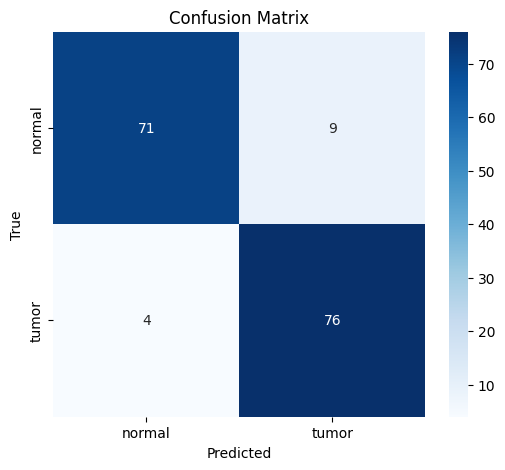


🔍 Classification Report:

              precision    recall  f1-score   support

      normal       0.95      0.89      0.92        80
       tumor       0.89      0.95      0.92        80

    accuracy                           0.92       160
   macro avg       0.92      0.92      0.92       160
weighted avg       0.92      0.92      0.92       160



In [24]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt

# Convert to numpy arrays
labels_np = np.array(labels)
preds_np  = np.array(preds)

# ---- METRICS ----
acc  = accuracy_score(labels_np, preds_np)
prec = precision_score(labels_np, preds_np)
rec  = recall_score(labels_np, preds_np)
f1   = f1_score(labels_np, preds_np)

print("📊 MODEL METRICS")
print("------------------------")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")

# ---- CONFUSION MATRIX ----
cm = confusion_matrix(labels_np, preds_np)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=train_ds.classes,
            yticklabels=train_ds.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ---- FULL CLASSIFICATION REPORT ----
print("\n🔍 Classification Report:\n")
print(classification_report(labels_np, preds_np, target_names=train_ds.classes))


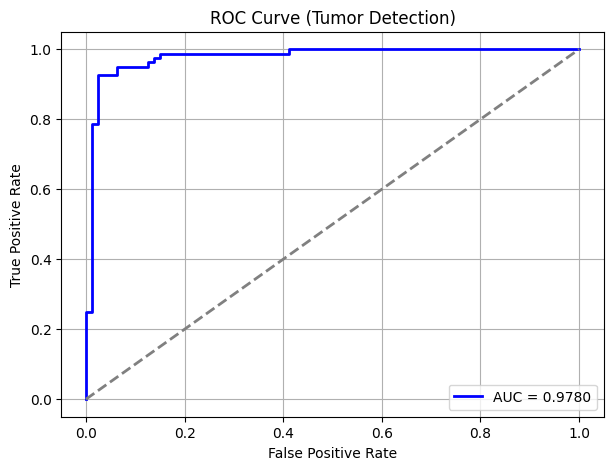

ROC AUC: 0.9779687499999999


In [25]:
import torch
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# --- compute ROC on test set ---
def compute_roc_auc():
    model.eval()
    probs_all = []
    labels_all = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            with torch.amp.autocast("cuda"):
                outputs = model(images)
                probs = torch.softmax(outputs, dim=1)[:, 1]  # probability of class "1" (tumor)

            probs_all.extend(probs.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())

    # Convert to numpy arrays
    probs_all = np.array(probs_all)
    labels_all = np.array(labels_all)

    # ROC values
    fpr, tpr, thresholds = roc_curve(labels_all, probs_all)
    roc_auc = auc(fpr, tpr)

    # --- Plot ---
    plt.figure(figsize=(7,5))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0,1], [0,1], color="gray", lw=2, linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Tumor Detection)")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    return roc_auc

# Run it
roc_auc = compute_roc_auc()
print("ROC AUC:", roc_auc)


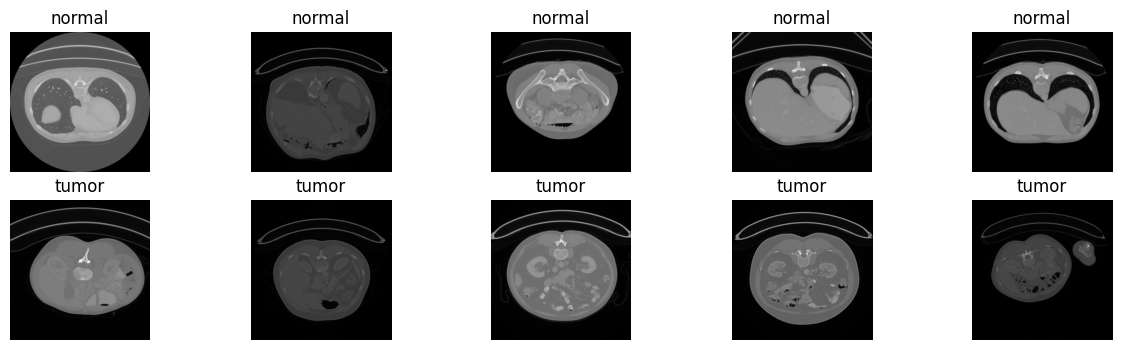

In [26]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

def show_random_test_images(n=5):
    paths = []

    for cls in ["normal", "tumor"]:
        folder = f"/content/small_pancreas_dataset_split/test/{cls}"
        files = os.listdir(folder)
        random_files = random.sample(files, min(n, len(files)))
        paths.extend([os.path.join(folder, f) for f in random_files])

    plt.figure(figsize=(15, 4))
    for i, p in enumerate(paths):
        plt.subplot(2, len(paths)//2, i + 1)
        plt.imshow(Image.open(p), cmap="gray")
        plt.title(os.path.basename(os.path.dirname(p)))
        plt.axis("off")
    plt.show()

show_random_test_images()


Total misclassified: 13


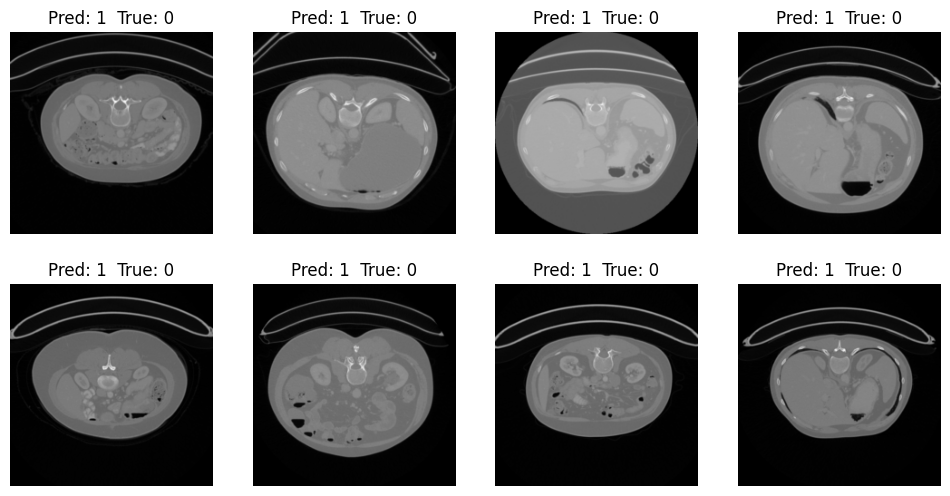

In [27]:
def show_misclassified():
    model.eval()
    wrong_images = []
    preds_list = []
    labels_list = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            with torch.amp.autocast("cuda"):
                outputs = model(images)
                _, preds = torch.max(outputs, 1)

            for img, pred, label in zip(images, preds, labels):
                if pred != label:
                    wrong_images.append(img.cpu())
                    preds_list.append(pred.item())
                    labels_list.append(label.item())

    print("Total misclassified:", len(wrong_images))

    # Show first 8 misclassified (if any)
    plt.figure(figsize=(12, 6))
    for i in range(min(8, len(wrong_images))):
        plt.subplot(2, 4, i+1)
        img = wrong_images[i]
        img = img.permute(1,2,0).numpy()
        img = (img * 0.5 + 0.5).clip(0,1)  # unnormalize
        plt.imshow(img, cmap="gray")
        plt.title(f"Pred: {preds_list[i]}  True: {labels_list[i]}")
        plt.axis("off")

    plt.show()

show_misclassified()


In [28]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.target_layer = target_layer

        self.gradients = None
        self.activations = None

        # Hook to save gradients
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        # Hook to save activations
        def forward_hook(module, input, output):
            self.activations = output

        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        input_tensor = input_tensor.requires_grad_(True)

        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = torch.argmax(output).item()

        self.model.zero_grad()
        loss = output[:, class_idx]
        loss.backward()

        gradients = self.gradients
        activations = self.activations

        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * activations, dim=1).squeeze()

        cam = F.relu(cam)
        cam = cam.detach().cpu().numpy()

        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

        return cam


In [29]:
test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


In [30]:
model.model.layer4[-1].conv3


Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)

In [31]:
target_layer = model.model.layer4[-1].conv3
cam = GradCAM(model, target_layer)


In [34]:
def visualize_gradcam(img_path):
    img = Image.open(img_path).convert("L")
    orig = np.array(img)

    # preprocess for model
    x = test_transforms(img).unsqueeze(0).to(device)

    # generate CAM
    cam_map = cam.generate(x)

    # heatmap 224×224
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_map), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255

    # resize original image to 224×224
    img_resized = cv2.resize(orig, (224, 224))
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB) / 255

    # overlay
    overlay = 0.4 * heatmap + 0.6 * img_rgb
    overlay = np.clip(overlay, 0, 1)

    # plot
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(orig, cmap="gray")
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(cam_map, cmap="jet")
    plt.title("Heatmap (Raw)")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title("Overlay")
    plt.axis("off")

    plt.show()


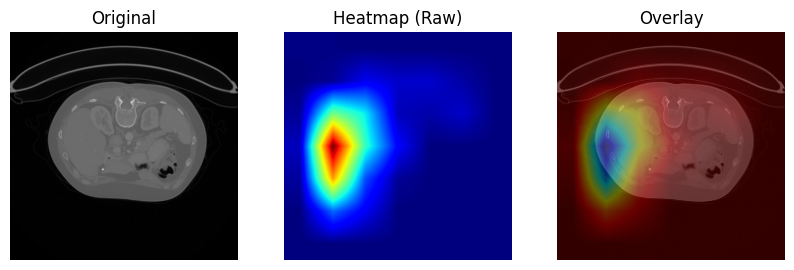

In [35]:
img_path = "/content/small_pancreas_dataset/tumor/img_00114.png"
visualize_gradcam(img_path)


In [37]:
def gradcam_image(img):
    img_pil = Image.fromarray(img).convert("L")
    orig = np.array(img_pil)

    # preprocess for model
    x = test_transforms(img_pil).unsqueeze(0).to(device)

    # generate CAM
    cam_map = cam.generate(x)

    # heatmap 224×224
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_map), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255.0

    # resize original to 224×224
    img_resized = cv2.resize(orig, (224, 224))
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB) / 255.0

    # overlay
    overlay = 0.4 * heatmap + 0.6 * img_rgb
    overlay = np.clip(overlay, 0, 1)

    overlay_uint8 = np.uint8(overlay * 255)

    return overlay_uint8


In [38]:
import csv
import time

FEEDBACK_FILE = "/content/feedback_log.csv"

# create file with header if missing
if not os.path.exists(FEEDBACK_FILE):
    with open(FEEDBACK_FILE, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["timestamp", "prediction", "probability_tumor", "probability_normal", "feedback"])


In [39]:
def save_feedback(pred_label, prob_tumor, prob_normal, feedback):
    with open(FEEDBACK_FILE, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            time.time(),
            pred_label,
            prob_tumor,
            prob_normal,
            feedback
        ])


In [40]:
def predict_ct(img):
    model.eval()

    import numpy as np
    from PIL import Image

    # convert numpy array → PIL
    img_pil = Image.fromarray(img).convert("L")

    # preprocess
    tensor = test_transforms(img_pil).unsqueeze(0).to(device)

    # inference
    with torch.no_grad():
        with torch.amp.autocast("cuda"):
            output = model(tensor)
            probs = torch.softmax(output, dim=1)[0]

    prob_normal = float(probs[0])
    prob_tumor = float(probs[1])

    # predicted label
    idx_to_label = {v: k for k, v in train_ds.class_to_idx.items()}
    pred_label = idx_to_label[int(torch.argmax(probs))]

    # GradCAM image
    cam_img = gradcam_image(img)

    # return multiple outputs
    return pred_label, {"normal": prob_normal, "tumor": prob_tumor}, cam_img


In [41]:
def feedback_fn(pred_label, prob_normal, prob_tumor, feedback):
    save_feedback(pred_label, prob_tumor, prob_normal, feedback)
    return "Feedback saved!"


In [42]:
with gr.Blocks() as demo:
    gr.Markdown("## 🩺 Pancreas Tumor Classifier with Grad-CAM + Feedback")

    with gr.Row():
        input_img = gr.Image(type="numpy", label="Upload CT Image")

    with gr.Row():
        pred_label = gr.Textbox(label="Prediction")
        pred_probs = gr.Label(label="Probabilities")
        cam_output = gr.Image(label="Grad-CAM Visualization")

    # Feedback UI
    feedback = gr.Radio(["correct", "incorrect"], label="Was the prediction correct?")
    feedback_button = gr.Button("Submit Feedback")
    feedback_status = gr.Textbox(label="Status")

    # Run prediction
    predict_button = gr.Button("Run Prediction")
    predict_button.click(
        fn=predict_ct,
        inputs=[input_img],
        outputs=[pred_label, pred_probs, cam_output]
    )

    # Save feedback
    feedback_button.click(
        fn=lambda fb, pl, probs: feedback_fn(
            pl, probs["normal"], probs["tumor"], fb
        ),
        inputs=[feedback, pred_label, pred_probs],
        outputs=[feedback_status]
    )

demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://33a9e7b381fb5a2a5b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
